# Data Slopes

Analisi di una giornata sullo snowboard

In [1]:
## import librerie

## generiche
import numpy as np
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
import datetime

## per grafici
import matplotlib.pyplot as plt
import seaborn as sns

## filtra_intersezioni
import shapely
from shapely.geometry import LineString


In [2]:
## creazione df

df1= pd.read_csv("data/gps-22-12-2024.csv",
    usecols=[0, 1, 2, 3, 6 ,7], 
    names=["unixtime", "latitudine", "longitudine", "altitudine", "precisione_orizzontale", "precisione_verticale"] ## 
    )

df1['unixtime'] = df1['unixtime'].round(0)

## righe duplicate in unixtime
df1 = df1[df1.duplicated(subset="unixtime", keep='first') == False].reset_index(drop=True) 

## finestra temporale utile
df1 = df1[(df1['unixtime'] > 1734859000) & (df1['unixtime'] < 1734878750)].reset_index(drop=True) 

## inserimento colonna per dati geospaziali
gdf1= gpd.GeoDataFrame(
    df1, 
    geometry= gpd.points_from_xy(df1['longitudine'], df1['latitudine']),
    crs= "EPSG:4326"  ## le coordinate usano gradi
)

gdf1 = gdf1.to_crs("EPSG:3857")


In [3]:
## creazione df ddi supporto

df_salite= pd.read_csv("data/salite.csv")
df_discese= pd.read_csv("data/discese.csv")

df_stato = pd.concat([df_salite, df_discese])
df_stato = df_stato.sort_values(by='unixtime_start')



In [4]:
## magic numbers

prezzo_skipass= 33.00

## Colori fissatia priori per stati

set1_colors = sns.color_palette("Set1", 10) 
colori_stato = {
    'Valvan': set1_colors[0],
    'Discesa': set1_colors[1],
    'Altro': set1_colors[2],
    'Cuel d’Ajar': set1_colors[3],
    'Giro d’Italia': set1_colors[4],
    'Ravascletto': set1_colors[5],
    'Valvan2': set1_colors[6],
}


 ## Il dataset originale

 Composto da 3300+ punti gps di cui sono noti:

- latitudine
- longitudine
- altezza in metri sul livello del mare
- precisione orizzontale
- precisone verticale

Presenta le solite anomalie di dati gps: jitter e valori anomali 

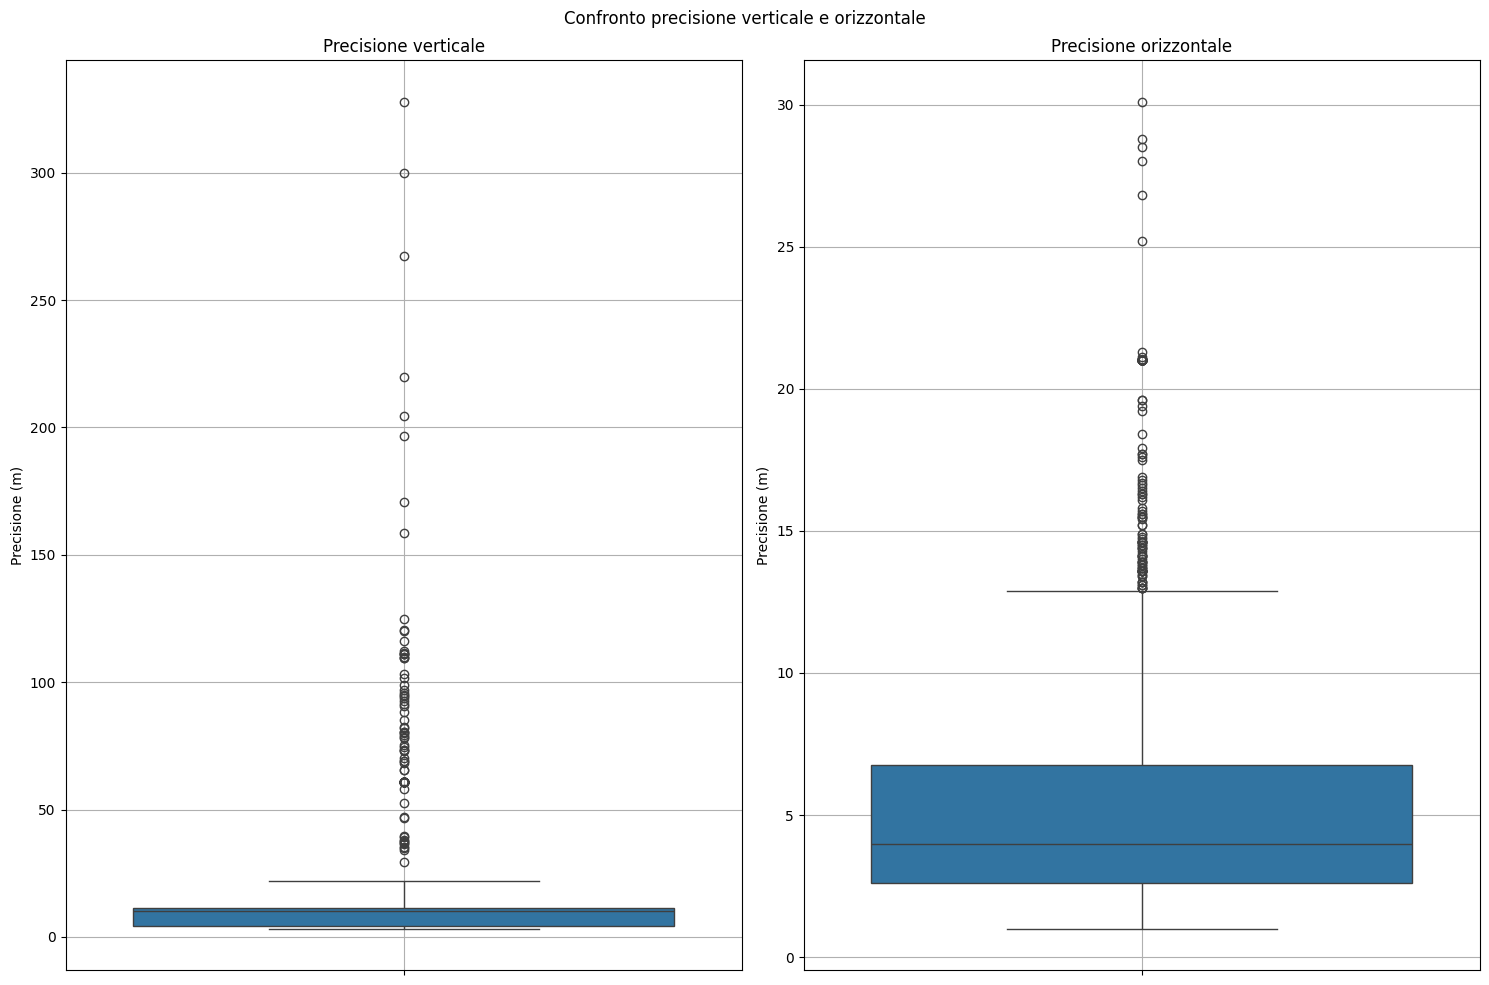

In [5]:
## Le due precisioni comparate

fig, axes = plt.subplots(1, 2, figsize=(15, 10))  ## 1 riga, 2 colonne

fig.suptitle('Confronto precisione verticale e orizzontale')
## precisione_verticale
sns.boxplot(ax=axes[0], y=gdf1['precisione_verticale'])
axes[0].set_title('Precisione verticale')
axes[0].set_ylabel('Precisione (m)')
axes[0].grid()

## precisione_orizzontale
sns.boxplot(ax=axes[1], y=gdf1['precisione_orizzontale'])
axes[1].set_title('Precisione orizzontale')
axes[1].set_ylabel('Precisione (m)')
axes[1].grid()

plt.tight_layout()
plt.show()

In [6]:
## Aggiungono informazioni derivate al dataframe

## Aggiunge colonna "delta_tempo"

def aggiungi_delta_tempo(gdf):
    gdf['delta_tempo'] = abs(gdf['unixtime'].diff()).fillna(0)
    
    return gdf

def aggiungi_delta_distanze(gdf):
    ## calcola la distanza orizzontale (non tiene conto del dislivello)
    gdf['distanza_orizzontale'] = gdf.geometry.distance(gdf.geometry.shift()).fillna(0) # shift: prende punto successivo

    ## calcola la distanza verticale
    gdf['distanza_verticale'] = gdf['altitudine'].diff().fillna(0) ## positiva: sale, negativa scende

    ## calcola la distanza reale 3D usando Pitagora: i = sqrt(c1^2 + c2^2)
    gdf['distanza_reale'] = np.sqrt(
        gdf['distanza_orizzontale']**2 + (gdf['distanza_verticale'])**2
    )

    return gdf

def aggiungi_pendenza(gdf):

    gdf['pendenza'] = np.degrees(np.arctan(gdf['distanza_verticale'] / gdf['distanza_orizzontale']))
    gdf['pendenza'] = gdf['pendenza'].fillna(0)
    
    return gdf

def aggiungi_velocita(gdf):

    gdf['velocita']= (gdf['distanza_reale'] / gdf['delta_tempo']).fillna(0)

    return gdf

def aggiungi_accelerazione(gdf):

    gdf['delta_velocita'] = gdf['velocita'].diff().fillna(0)

    gdf['accelerazione'] = (gdf['delta_velocita'] / gdf['delta_tempo']).fillna(0)
    
    return gdf

def aggiungi_accelerazione_max(gdf):
    # Converti la pendenza da gradi a radianti
    gdf['pendenza_radianti'] = np.radians(gdf['pendenza'])

    # Calcola l'accelerazione massima teorica
    gdf['accelerazione_max'] = 9.81 * np.sin(gdf['pendenza_radianti'])

    return gdf

In [7]:
## Filtri su grandezze primarie
## Questi filtri eliminano dati in base a informazioni primaria(non derivate) nel dataframe
## Poco costosi

def filtro_precisione(gdf, precisione_orizzontale=10, precisione_verticale=10):

    gdf_filtrato = gdf.loc[
        (gdf['precisione_orizzontale'] <= precisione_orizzontale) &
        (gdf['precisione_verticale'] <= precisione_verticale)
    ].reset_index(drop=True)
    
    return gdf_filtrato

def filtra_temporalmente(gdf, min_tempo=1):

    # Lista per le righe da mantenere
    valid_rows = [0]  # Mantieni sempre il primo punto

    # Itera attraverso i punti
    for i in range(1, len(gdf)):
        # Calcola il tempo tra il punto corrente e l'ultimo punto valido
        delta_tempo = gdf.iloc[i]['unixtime'] - gdf.iloc[valid_rows[-1]]['unixtime']
        
        # Se la differenza di tempo è sufficiente, aggiungi il punto alla lista
        if delta_tempo >= min_tempo:
            valid_rows.append(i)
    
    # Filtra il DataFrame
    gdf_filtrato = gdf.iloc[valid_rows].reset_index(drop=True)
    
    return gdf_filtrato

## trova intersezioni geometriche fra punti troppo vicini
## dovrebbe eliminare jitter jps 
def filtro_intersezioni(gdf, max_time_diff=60*1):

    punti_da_rimuovere = []  ## Lista per i punti da rimuovere
    segmenti = [] ## i segmenti che uniscono 2 punti

    ## crea segmenti
    for i in range(len(gdf) - 1):
        ## un segmento è fatto dal punto d'inizio e il punto di fine con relativi timestamp
        punto1 = (gdf.loc[i, "longitudine"], gdf.loc[i, "latitudine"])
        punto2 = (gdf.loc[i + 1, "longitudine"], gdf.loc[i + 1, "latitudine"])
        tempo1 = gdf.loc[i, "unixtime"]
        tempo2 = gdf.loc[i + 1, "unixtime"]

        ## il segmento diventa un tipo LineString
        segmento = LineString([punto1, punto2])

        ## aggiunge il segmento con i timestamp e gli indici
        segmenti.append((   segmento, 
                            tempo1, 
                            tempo2, 
                            i, 
                            i + 1))  

    ## controlla le intersezioni
    for i in range(len(segmenti)):
        j = i + 2   ## partiamo dal segmento successivo, 
                    ## 2 punti più in la per evitare intersezioni in un punto singolo!!!

        while j < len(segmenti) and abs(segmenti[i][2] - segmenti[j][1]) <= max_time_diff:  
            segmento1 = segmenti[i][0]  ## il primo valore della tupla è un segmento
            segmento2 = segmenti[j][0]  

            if segmento1.intersects(segmento2):  ## se si intersecano
                punti_da_rimuovere.append(segmenti[i][4])  ## elimina i punti di indice i e j
                #punti_da_rimuovere.append(segmenti[j][3])  ## [3]: i [4]:i+1 

            j += 1  # Passa al segmento successivo
            ##if
        ##while
    ##for
    ## segmenti intersecanti trovati

    gdf = gdf.drop(punti_da_rimuovere).reset_index(drop=True)

    return gdf


In [8]:
## filtra il df in base ai limiti fisici delle grandezze derivate. 
## COSTOSO

def filtra_df(gdf_orig, min_acc=-4, max_acc=4):

    gdf=gdf_orig.copy() ## gdf.loc[]...

    cambiato = True
    while cambiato:

        gdf = aggiungi_delta_tempo(gdf)
        gdf = aggiungi_delta_distanze(gdf)
        gdf = aggiungi_pendenza(gdf)
        gdf = aggiungi_velocita(gdf)
        gdf = aggiungi_accelerazione(gdf)
        gdf = aggiungi_accelerazione_max(gdf)
        
        lunghezza_pre = len(gdf)
        ## Filtra per accelerazione
        gdf = gdf[(gdf['accelerazione'] >= min_acc) & (gdf['accelerazione'] <= max_acc)]

        lunghezza_post = len(gdf)
        # Se sono state eliminate righe, ripeti il ciclo
        if lunghezza_post < lunghezza_pre:
            cambiato = True
        else:
            cambiato = False

    return gdf

In [9]:
## Filtri dati primari dataset

gdf1 = filtro_precisione(gdf1, precisione_orizzontale=20, precisione_verticale= 20)

gdf1= filtro_intersezioni(gdf1, max_time_diff=60*1)

In [10]:
## Inserimento di grandezze derivate

gdf1 = aggiungi_delta_tempo(gdf1)

gdf1= aggiungi_delta_distanze(gdf1)

gdf1= aggiungi_pendenza(gdf1)

gdf1= aggiungi_velocita(gdf1)

gdf1 = aggiungi_accelerazione(gdf1)

gdf1= aggiungi_accelerazione_max(gdf1)

In [11]:
## Filtro in base alla fisica su grandezze derivate

gdf1= filtra_df(gdf1, min_acc=-3, max_acc=3)

#gdf1.describe()

In [12]:
time_start = gdf1['unixtime'].iloc[0]
time_end = gdf1['unixtime'].iloc[-1]

time_delta= time_end - time_start

tempo_trascorso_hms = str(datetime.timedelta(seconds=time_delta))
#print(tempo_trascorso_hms)


In [13]:
## altr funzioni 

def calcola_distanza_percorsa(gdf):

    distanza_percorsa = [0]  
    for i in range(1, len(gdf)):
        coord1 = (gdf.iloc[i-1]['latitudine'],gdf.iloc[i-1]['longitudine'])
        coord2 = (gdf.iloc[i]['latitudine'], gdf.iloc[i]['longitudine'])
        distanza = geodesic(coord1, coord2).meters
        distanza_percorsa.append(distanza_percorsa[-1] + distanza)

    gdf['distanza_percorsa'] = distanza_percorsa

    return gdf

## Il dataset finale

Composto da 3000+ punti gps **originali** a cui sono state aggiunte le informazioni relative a:

- scarto temporale
- velocità
- accelerazione
- distanza fra punti
- ...

Il filtraggio dei dati:

- precisione musurazioni ($\pm$ 20 metri)
- intersezione fra segmenti temporalmente vicini (1 minuto )
- limiti fisici di accelerazione ($\pm$ 3 m/s)

Questi dati sono più attendibili

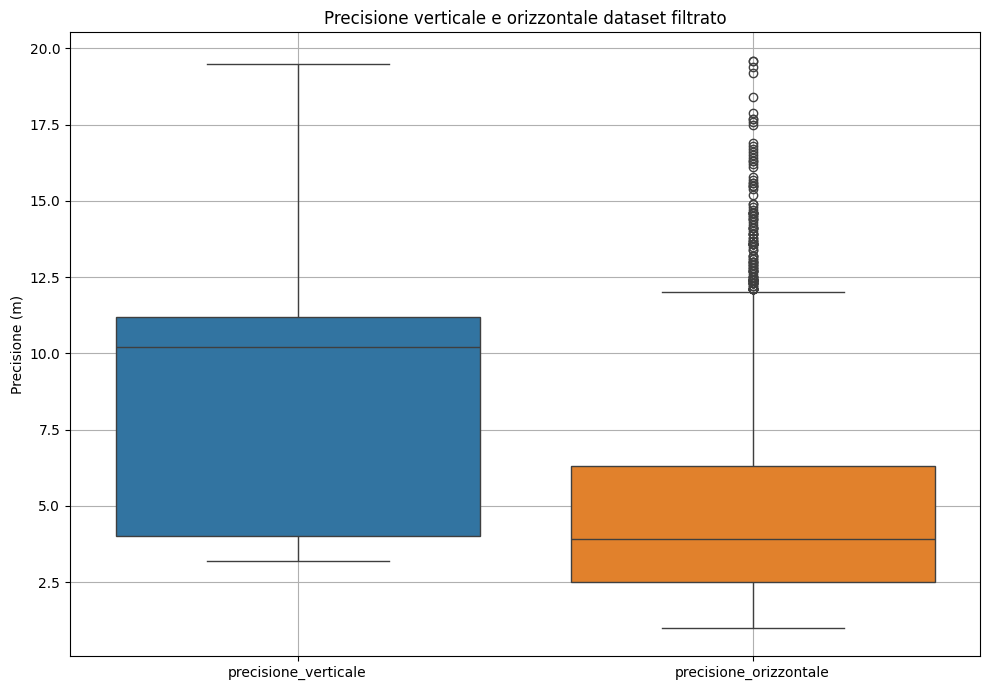

In [14]:
plt.figure(figsize=(10, 7))


sns.boxplot(data=gdf1[['precisione_verticale', 'precisione_orizzontale']])

plt.title('Precisione verticale e orizzontale dataset filtrato')
plt.ylabel('Precisione (m)')
plt.grid()

plt.tight_layout()
plt.show()

## Com'è andata la giornata?

### Il profilo di giornata

Ho registrato 10 discese in un periodo di circa 5 ore e mezza (5:28:21), accumulando una verticale totale di discesa di 4387 metri.

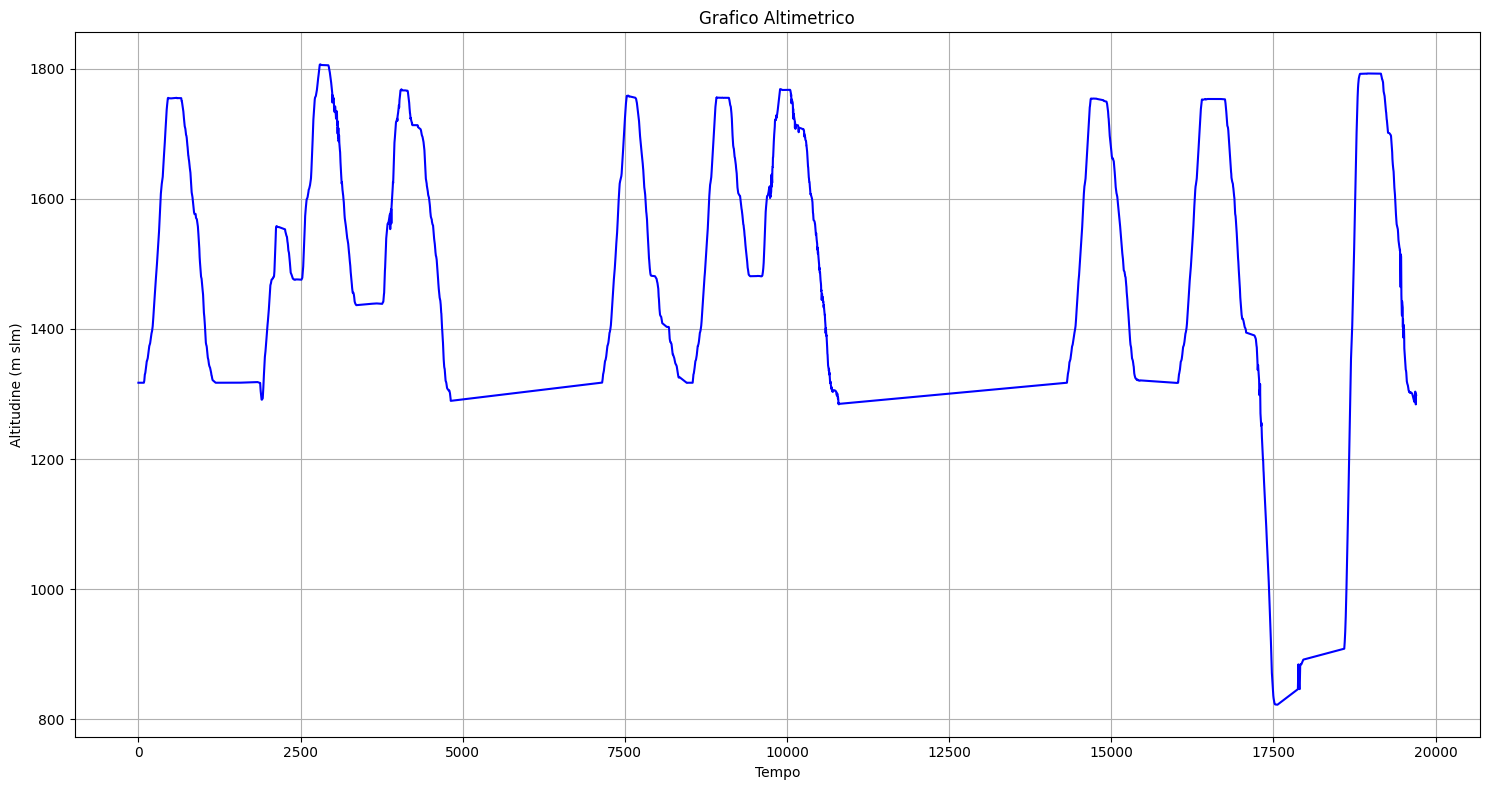

In [15]:
## Altimetria della giornata
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________


plt.figure(figsize=(15, 8)) ## test grandezza grafico

plt.title('Grafico Altimetrico')

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['altitudine'], 
    label='Altitudine', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Altitudine (m slm)')

plt.grid()

plt.tight_layout()
plt.show()


In [16]:
## calcolo delle verticali
verticali_discese = []

for idx, row in df_discese.iterrows():

    discesa_data = gdf1[(gdf1['unixtime'] >= row['unixtime_start']) & 
                        (gdf1['unixtime'] <= row['unixtime_end'])]

    altitudine_inizio = discesa_data.iloc[0]['altitudine']  # start
    altitudine_fine = discesa_data.iloc[-1]['altitudine']  # end
    
    verticale = altitudine_inizio - altitudine_fine

    verticali_discese.append(verticale)

df_discese['verticale'] = verticali_discese


#print(df_discese['verticale'].sum())

## Uso del tempo

La giornata è stata divisa in scaglioni temporali etichettati in base all'attività:

- le risalite hanno il nome delle funivie :
  - Cuel D'ajar
  - Valvan
  - Giro d'Italia
  - Ravascletto
- le discese sono clusterizzate in un unico insieme: le piste offrono molte varianti!
- la classificazione "Altro" comprende il tempo utilizzato per:
  - mangiare
  - spostarsi fra gli impianti di risalita
  - tempo in coda

In [17]:
## Analisi temporale

gdf1['stato'] = 'Altro'

## 
for _, row in df_stato.iterrows():
    ## maschera con unixtime
    mask = (gdf1['unixtime'] >= row['unixtime_start']) & (gdf1['unixtime'] <= row['unixtime_end'])
    
    ## lo stato è presente nel df stato
    gdf1.loc[mask, 'stato'] = row['stato']


In [18]:

tempo_per_stato = gdf1.groupby('stato')['delta_tempo'].sum().reset_index()
tempo_per_stato.columns = ['stato', 'tempo_totale']

conteggio_stati = df_stato['stato'].value_counts().reset_index()
conteggio_stati.columns= [ 'stato', 'conteggio']


tempo= pd.merge(conteggio_stati, tempo_per_stato, on='stato', how='right').fillna(0)

## evita divisioni per infinito
tempo.loc[(tempo['stato'] == 'Altro') & (tempo['conteggio'] == 0.0), 'conteggio'] = 1

tempo['tempo_medio']= tempo['tempo_totale'] / tempo['conteggio']
tempo['tempo_percentuale']= (tempo['tempo_totale'] / time_delta) * 100

tempo['tempo_totale_minuti'] = tempo['tempo_totale']/ 60

tempo['tempo_medio_minuti'] = tempo['tempo_medio'] / 60

tempo['tempo_totale_formattato'] = tempo['tempo_totale'].apply(lambda x: str(datetime.timedelta(seconds=x)))
tempo['tempo_medio_formattato'] = tempo['tempo_medio'].apply(lambda x: str(datetime.timedelta(seconds=x)))


## calocolo tempo totale in risalita
tempo_risalite = tempo[tempo['stato'] != 'Altro']

tempo_risalite= tempo_risalite[tempo_risalite['stato']!= 'Discesa']

## Calcolare il tempo totale in risalita
tempo_totale_risalite = tempo_risalite['tempo_totale'].sum()

#print(tempo_totale_risalite)
#print(str(datetime.timedelta(seconds=tempo_totale_risalite)))
#print(str(datetime.timedelta(seconds=5858)))

colori_impianti_risalita = tempo['stato'].map(colori_stato).fillna('graey') 

## ordinato in basea al tempo tot
tempo_sorted = tempo.sort_values(by='tempo_totale_minuti', ascending=False)
colori_impianti_risalita = tempo_sorted['stato'].map(colori_stato).fillna('graey')  

#tempo.head(10)


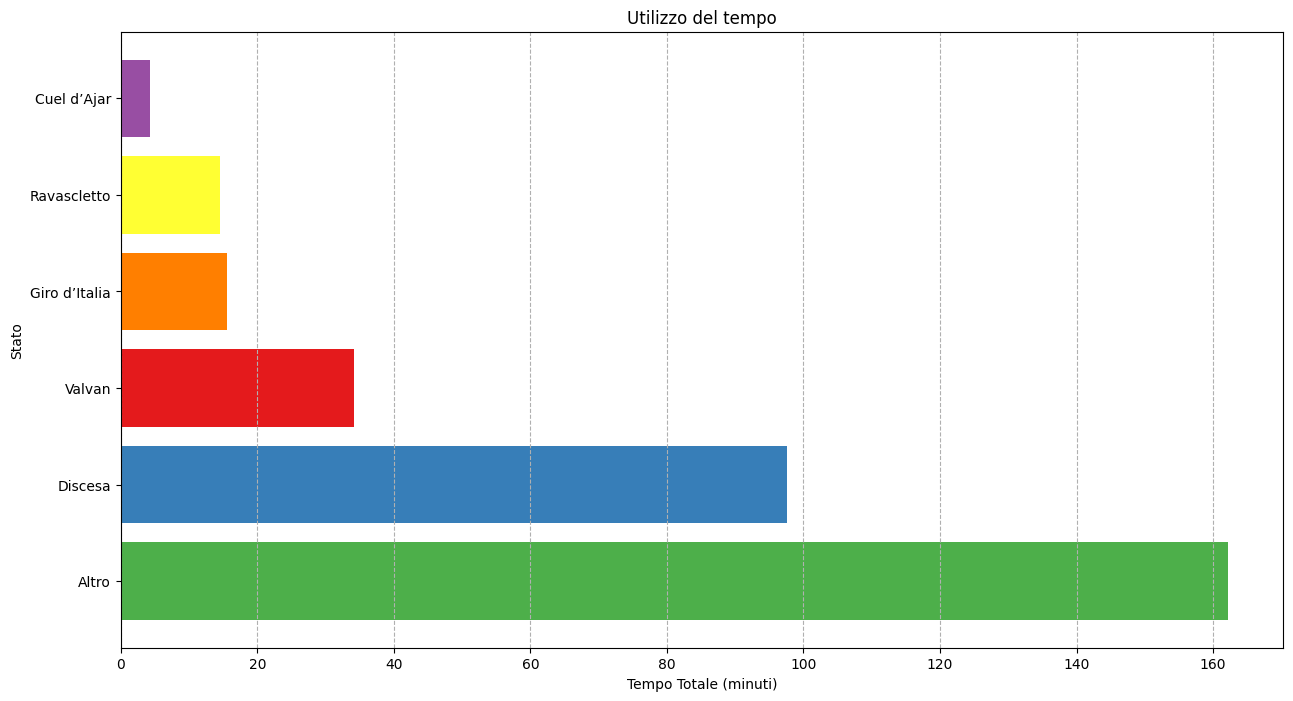

In [19]:
plt.figure(figsize=(15, 8))
plt.title('Utilizzo del tempo')

plt.barh(tempo_sorted['stato'], 
        tempo_sorted['tempo_totale_minuti'], 
        color=colori_impianti_risalita
        )

plt.xlabel('Tempo Totale (minuti)')
plt.ylabel('Stato')
plt.grid(axis='x', 
        linestyle='--')

plt.show()



Non sembro una persona molto sportiva: 

- Il 49.4% del tempo (2:42:10) è stato impiegato per fare altro
- Il 29.7% del tempo (1:37:38) è stato utilizzato per scendere sulle piste
- Il 22.7% del tempo (1:08:33) è stato utilizzato per salire sugli impianti


## Più pendente = più veloce?

Analizziamo il grafico delle velocità

In [20]:
## statistiche di discesa
velocita_medie_discese = []
velocita_mediane_discese = []

for idx, row in df_discese.iterrows():

    discesa_data = gdf1[(gdf1['unixtime'] >= row['unixtime_start']) & 
                        (gdf1['unixtime'] <= row['unixtime_end'])]
    
    velocita_media = discesa_data['velocita'].mean() * 3.6
    velocita_mediana = discesa_data['velocita'].median() *3.6
    
    velocita_medie_discese.append(velocita_media)
    velocita_mediane_discese.append(velocita_mediana)

df_discese['velocita_media'] = velocita_medie_discese
df_discese['velocita_mediana'] = velocita_mediane_discese

df_discese.head(10)

crociera= df_discese['velocita_mediana'].median()

#print(crociera)

velocita_max= gdf1['velocita'].max()* 3.6
#print(velocita_max)

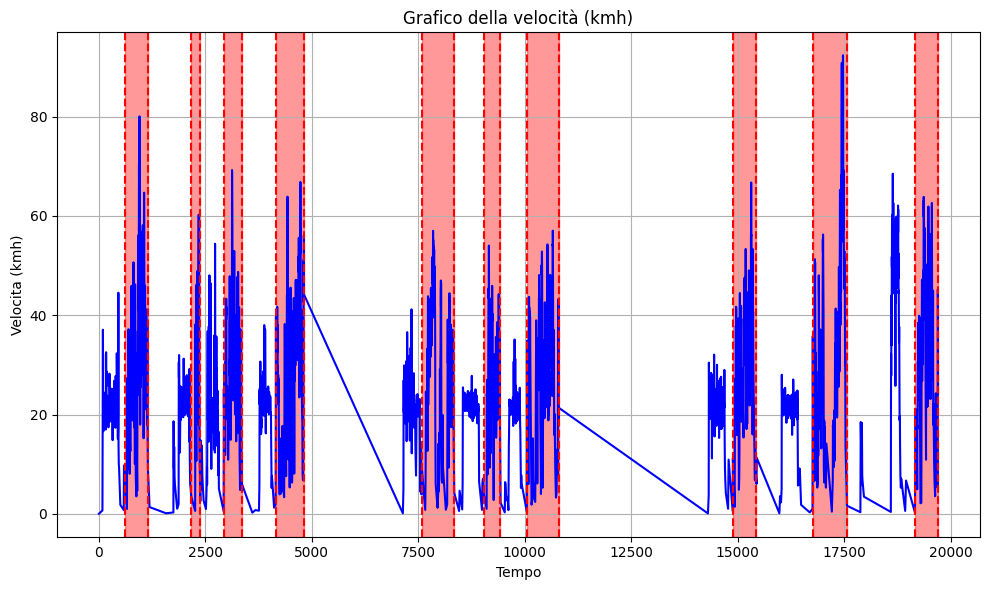

In [21]:
## Velocità della giornata

plt.figure(figsize=(10, 6)) ##

plt.title('Grafico della velocità (kmh)')

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['velocita'] * 3.6, 
    label='velocità', 
    color='blue')

## evidenzia le discese
for idx, row in df_discese.iterrows():

    ## box
    plt.axvspan(row['unixtime_start'] - time_start, 
                row['unixtime_end'] - time_start, 
                color='red', 
                alpha=0.4)  

    ## linea start
    plt.axvline(x=row['unixtime_start'] - time_start, 
                color='red', 
                linestyle='--'
                )
    ## linea end
    plt.axvline(x=row['unixtime_end'] - time_start, 
                color='red', 
                linestyle='--')

plt.xlabel('Tempo')
plt.ylabel('Velocita (kmh)')

plt.grid()

plt.tight_layout()
plt.show()

Il grafico sembra essere soggetto a molto rumore...

- imprecisione dello strumento
- stile di discesa

Risulta comunque possibile estrapolare informazioni utili:

- velocià massima rilevata: 92 km/h 🪖
- velocità di crociera: 32 km/h  

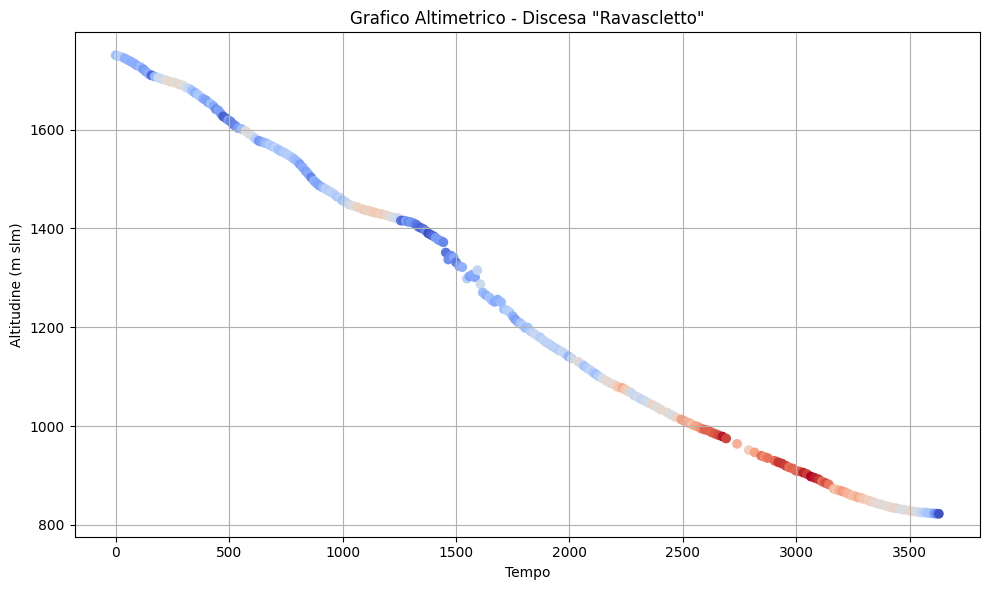

In [22]:
## analisi discesa Ravascletto

timestart_discesa_9 = df_discese.iloc[8]['unixtime_start']
timeend_discesa_9 = df_discese.iloc[8]['unixtime_end']


gdf1_discesa_9 = gdf1[(gdf1['unixtime'] >= timestart_discesa_9) & 
                      (gdf1['unixtime'] <= timeend_discesa_9)].reset_index(drop=True)


gdf1_discesa_9 = calcola_distanza_percorsa(gdf1_discesa_9)


plt.figure(figsize=(10, 6))

plt.title('Grafico Altimetrico - Discesa "Ravascletto"')

plt.scatter(gdf1_discesa_9['distanza_percorsa'], 
                 gdf1_discesa_9['altitudine'], 
                 c=gdf1_discesa_9['velocita'] * 3.6, 
                 cmap='coolwarm'
                 ) 

plt.xlabel('Tempo')
plt.ylabel('Altitudine (m slm)')

plt.grid(True)

plt.tight_layout()
plt.show()


La veloctà massima è stata raggiunta a fine pista, prima di un falso piano

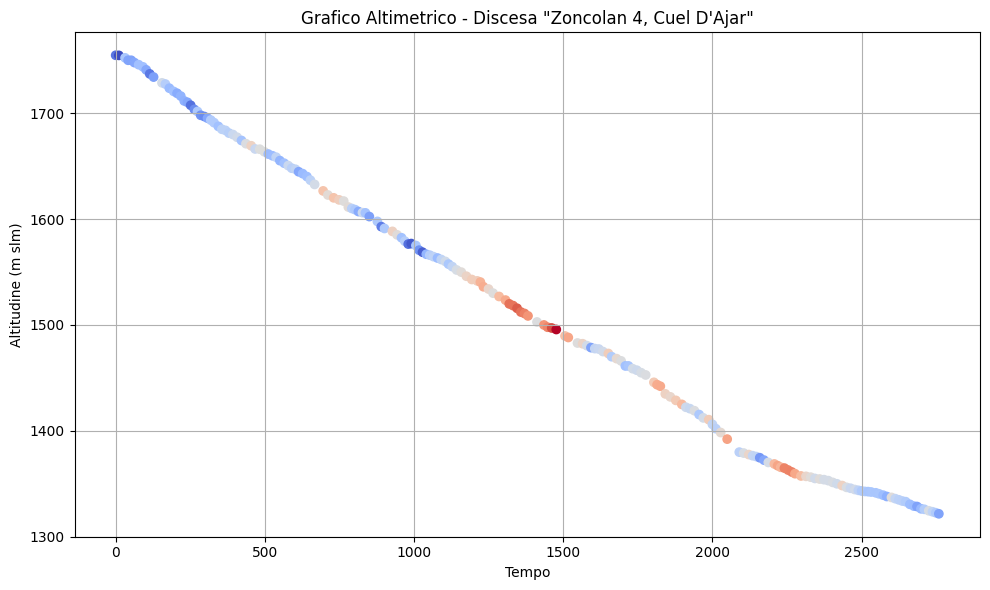

In [23]:
## prima discesa

timestart_discesa_1 = df_discese.iloc[0]['unixtime_start']
timeend_discesa_1 = df_discese.iloc[0]['unixtime_end']


gdf1_discesa_1 = gdf1[(gdf1['unixtime'] >= timestart_discesa_1) & 
                      (gdf1['unixtime'] <= timeend_discesa_1)].reset_index(drop=True)

gdf1_discesa_1 = calcola_distanza_percorsa(gdf1_discesa_1)


plt.figure(figsize=(10, 6))

plt.title('Grafico Altimetrico - Discesa "Zoncolan 4, Cuel D\'Ajar"')

plt.scatter(gdf1_discesa_1['distanza_percorsa'], 
                 gdf1_discesa_1['altitudine'], 
                 c=gdf1_discesa_1['velocita'] * 3.6, 
                 cmap='coolwarm'
                 ) 

plt.xlabel('Tempo')
plt.ylabel('Altitudine (m slm)')

plt.grid(True)

# Mostrare il grafico
plt.tight_layout()
plt.show()


Anche in questa discesa la velocità massima è stata raggiunta alla fine di una discesa, prima di un tratto pianeggiante.

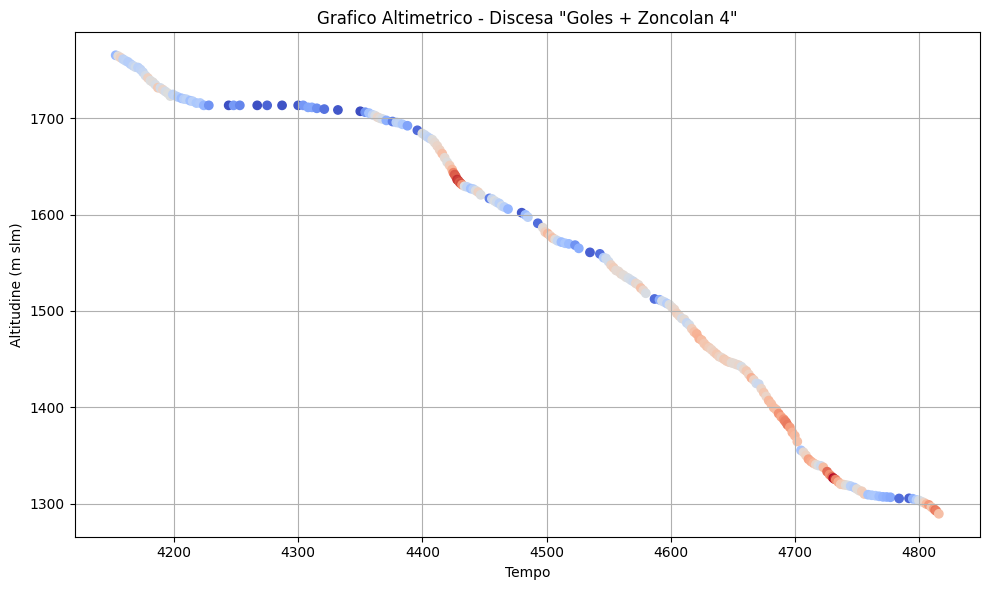

In [24]:
## analisi discesa "Tamai"

timestart_discesa_4 = df_discese.iloc[3]['unixtime_start']
timeend_discesa_4 = df_discese.iloc[3]['unixtime_end']


gdf1_discesa_4 = gdf1[(gdf1['unixtime'] >= timestart_discesa_4) & 
                      (gdf1['unixtime'] <= timeend_discesa_4)].reset_index(drop=True)

                      

plt.figure(figsize=(10, 6))

plt.title('Grafico Altimetrico - Discesa "Goles + Zoncolan 4"')

plt.scatter(gdf1_discesa_4['unixtime'] - time_start, 
                 gdf1_discesa_4['altitudine'], 
                 c=gdf1_discesa_4['velocita'] * 3.6, 
                 cmap='coolwarm'
                 )


plt.xlabel('Tempo')
plt.ylabel('Altitudine (m slm)')

plt.grid(True)

# Mostrare il grafico
plt.tight_layout()
plt.show()


In tutte e tre le discese prese in considerazione la velocità massima si raggiunge alla fine di una discesa, poco prima di un tratto pianeggiante.

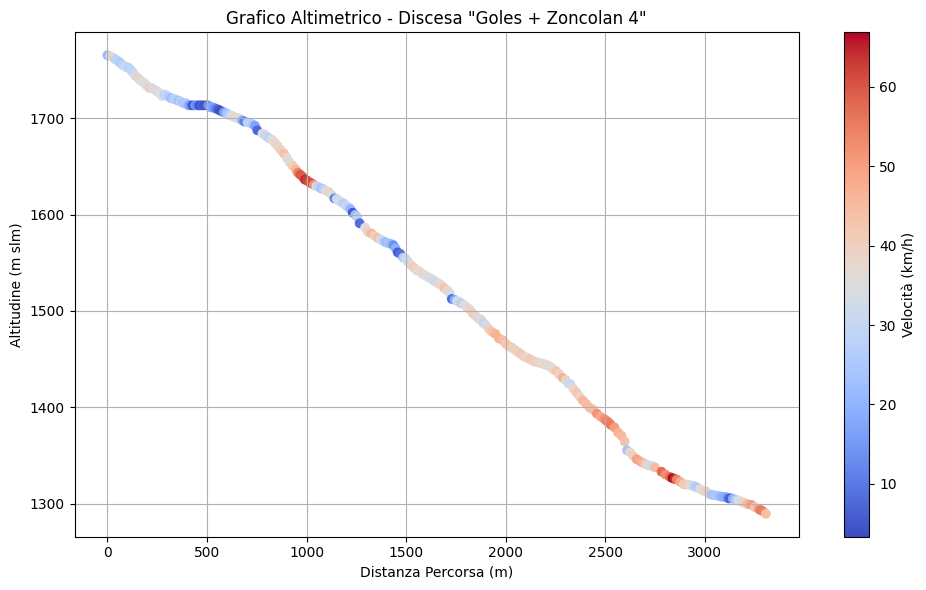

In [25]:

gdf1_discesa_4 = calcola_distanza_percorsa(gdf1_discesa_4)

# Traccia il grafico di dispersione con la distanza percorsa e l'altitudine
plt.figure(figsize=(10, 6))

plt.title('Grafico Altimetrico - Discesa "Goles + Zoncolan 4"')

plt.scatter(gdf1_discesa_4['distanza_percorsa'], 
            gdf1_discesa_4['altitudine'], 
            c=gdf1_discesa_4['velocita'] * 3.6,  # Velocità in km/h
            cmap='coolwarm'
            )

# Aggiungi una barra della scala del colore
plt.colorbar(label='Velocità (km/h)')

plt.xlabel('Distanza Percorsa (m)')
plt.ylabel('Altitudine (m slm)')
plt.grid(True)

# Mostrare il grafico
plt.tight_layout()
plt.show()



## tempo risalita vs tempo discesa per ogni pista

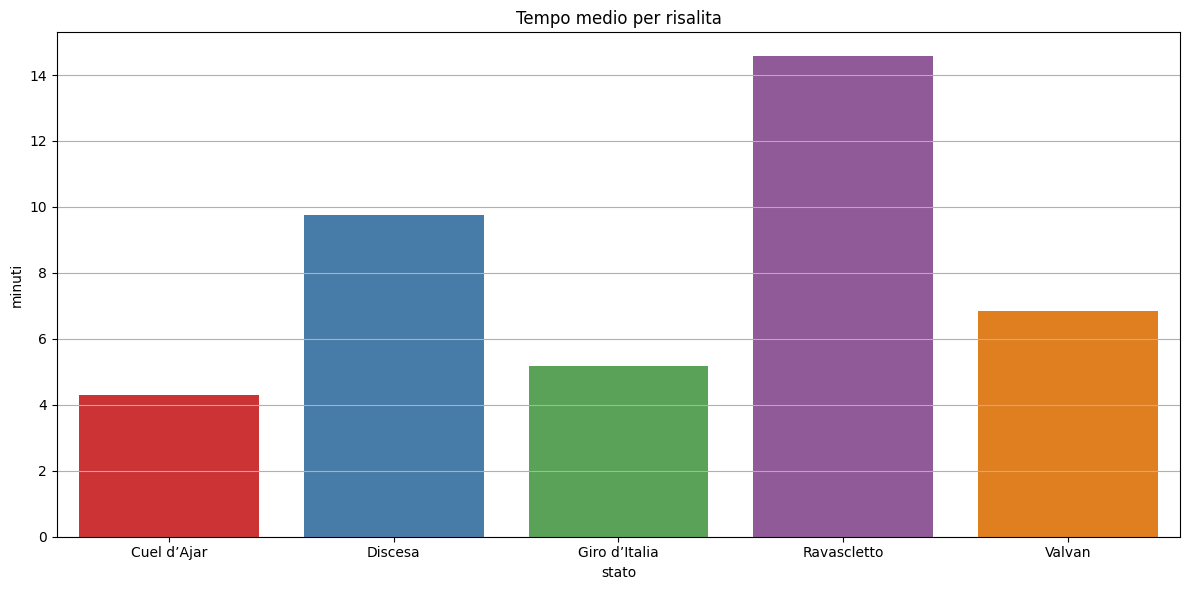

In [26]:
tempo_attivo = tempo[tempo['stato'] != 'Altro']

#
plt.figure(figsize=(12, 6))

plt.title('Tempo medio per risalita')

sns.barplot(data=tempo_attivo, 
            x='stato', 
            y='tempo_medio_minuti', 
            hue='stato',
            palette='Set1'
            )

plt.ylabel('minuti')

plt.grid(plt.grid( axis='x',
        linestyle='--'))
plt.tight_layout()
plt.show()

